# Cleaning and Analysis #

## Import APIs ##

In [1]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wfdb
import ast

## Load data ##

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
sampling_rate=100

# load and convert annotation data
uncleaned_ptbxl_df = pd.read_csv('./ptb-xl/ptbxl_database.csv', index_col='ecg_id')
uncleaned_ptbxl_df.scp_codes = uncleaned_ptbxl_df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
raw_sig_data = load_raw_data(uncleaned_ptbxl_df, sampling_rate, './ptb-xl/')

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('./ptb-xl/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
uncleaned_ptbxl_df['diagnostic_superclass'] = uncleaned_ptbxl_df.scp_codes.apply(aggregate_diagnostic)

## Cleaning Metadata ##

In [6]:
uncleaned_ptbxl_df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


In [7]:
print(f'Shape of uncleaned PTB-XL database: {uncleaned_ptbxl_df.shape}\n')
print(f'Null values:\n{uncleaned_ptbxl_df.isnull().sum()}')

Shape of uncleaned PTB-XL database: (21799, 28)

Null values:
patient_id                          0
age                                 0
sex                                 0
height                          14825
weight                          12378
nurse                            1473
site                               17
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8468
infarction_stadium1             16187
infarction_stadium2             21696
validated_by                     9378
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20201
static_noise                    18539
burst_noise                     21186
electrodes_problems             21769
extra_beats                     19850
pacemaker                       21508
strat_fold                

In [8]:
# Drop unneeded columns from old dataframe
ptbxl_metadata = uncleaned_ptbxl_df.loc[:, ['age', 'sex', 'device', 'validated_by_human', 'diagnostic_superclass', 'strat_fold', 'filename_lr', 'filename_hr']].copy()

In [9]:
ptbxl_metadata.head()

,age,sex,device,validated_by_human,diagnostic_superclass,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,
1,56.0,1,CS-12 E,True,[NORM],3,records100/00000/00001_lr,records500/00000/00001_hr
2,19.0,0,CS-12 E,True,[NORM],2,records100/00000/00002_lr,records500/00000/00002_hr
3,37.0,1,CS-12 E,True,[NORM],5,records100/00000/00003_lr,records500/00000/00003_hr
4,24.0,0,CS-12 E,True,[NORM],3,records100/00000/00004_lr,records500/00000/00004_hr
5,19.0,1,CS-12 E,True,[NORM],4,records100/00000/00005_lr,records500/00000/00005_hr


In [11]:
# Generate new CSV files
file_name = "cleaned_ptbxl_metadata.csv"
target_file = os.path.join("./cleaned_data", file_name)
    
f = open(target_file, "w")
ptbxl_metadata.to_csv(f)
f.close()

## Waveform data ##

In [12]:
def create_waveform_df(record_path, segment_length=1000, start_index=0):
    # Load the waveform record and annotation
    record = wfdb.rdrecord(f'./ptb-xl/{record_path}')
    
    # Extract the signal and select a segment
    signal = record.p_signal[start_index:start_index + segment_length, :]
    time = np.arange(start_index, start_index + segment_length) / 100  # Create a time array in seconds
    
    waveform_df = pd.DataFrame(signal)
    waveform_df.index = time
    waveform_df.index.name = 'Time (s)'
    waveform_df.columns = record.sig_name
    
    return waveform_df

In [13]:
record_path = ptbxl_metadata['filename_hr'].iloc[0]
waveform_df = create_waveform_df(record_path)
waveform_df

,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,V5,V6
Time (s),,,,,,,,,,,,
0.00,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
0.01,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
0.02,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
0.03,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
0.04,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
...,...,...,...,...,...,...,...,...,...,...,...,...
9.95,0.005,-0.020,-0.025,0.008,0.015,-0.022,0.005,0.025,0.015,0.015,-0.010,0.040
9.96,0.033,-0.021,-0.053,-0.005,0.043,-0.037,0.001,0.021,0.011,0.007,-0.014,0.032
9.97,-0.011,-0.051,-0.039,0.031,0.015,-0.045,-0.003,0.016,0.006,0.002,-0.018,0.024


In [14]:
# Generated with the help of ChatGPT
def plot_waveform(record_path, segment_length=1000, start_index=0):
    """
    Function to plot a segment of an ECG waveform.

    Args:
    - record_name (str): The name of the record file without file extension.
    - segment_length (int): The number of samples to include in the plot.
    - start_index (int): The index of the first sample in the segment to plot.
    """
    # Load the waveform record and annotation
    record = wfdb.rdrecord(f'./ptb-xl/{record_path}')
    
    # Create waveform dataframe
    waveform_df = create_waveform_df(record_path)

    # Plot the signal
    plt.figure(figsize=(12, 6))
    for col in waveform_df.columns:
        plt.plot(waveform_df.index, waveform_df[col], label=f'Lead {col}')
    
    plt.title('ECG Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

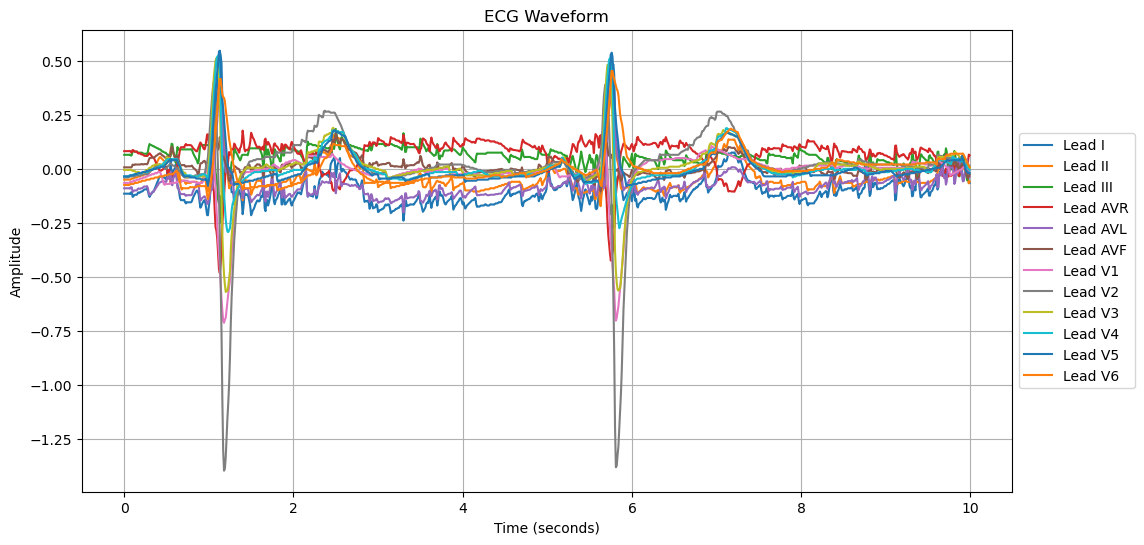

In [15]:
record_path = ptbxl_metadata['filename_hr'].iloc[0]
plot_waveform(record_path)

In [16]:
# Generate new CSV files
for ecg_id in ptbxl_metadata.index:
    ecg_record = ptbxl_metadata.loc[ecg_id]
    
    record_path = ecg_record['filename_hr']
    waveform_df = create_waveform_df(record_path)

    # Make new directory that corresponds to original record path
    new_dir = './cleaned_data/waveform_data/records500/' + record_path[11:16]
    os.makedirs(new_dir, exist_ok=True)
    file_name = record_path[-8:] + '.csv'
    target_file = os.path.join(new_dir, file_name)

    f = open(target_file, "w")
    waveform_df.to_csv(f)
    f.close()